In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shapefile as shp
import urllib, geojson, gdal, subprocess
import json
import requests
import folium
import datetime
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from bokeh.models import ColumnDataSource,FactorRange
from bokeh.plotting import figure
from bokeh.models import Panel, Tabs
from bokeh.io import output_file, show
from bokeh.io import curdoc
from bokeh.io import output_notebook
from bokeh.models import Legend
from bokeh.palettes import Spectral6
from bokeh.transform import factor_cmap
from bokeh.palettes import Category20_14 as palette
from bokeh.palettes import Category20b_14 as palette2
import itertools
from bokeh.models.tools import HoverTool
from bokeh.layouts import row
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")


sns.set(style= 'whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(10,6))
# Set a plot style for nice plots.
plt.style.use('ggplot')

# Magic command useful jupyter notebook
%matplotlib inline

#Set plot size.
plt.rcParams['figure.figsize'] = [13,7]

#Set font size
plt.rcParams.update({'font.size':16})

Link to the website where the motor vehicle data was found [Crash Data](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95), [Vehicle Data](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Vehicles/bm4k-52h4) and [Persons Data](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Person/f55k-p6yu)

In [181]:
df_crash = pd.read_csv('crash_clean.csv')
df_vehicle = pd.read_csv('vehicle_clean.csv')
df_persons = pd.read_csv('people_clean.csv')

In [120]:
df_crash['CRASH DATE'] = pd.to_datetime(df_crash['CRASH DATE'],errors='coerce')
df_crash['CRASH TIME'] = pd.to_datetime(df_crash['CRASH TIME'],errors='coerce')

In [121]:
df_crash.head()

,Unnamed: 0,CRASH DATE,CRASH TIME,BOROUGH,LATITUDE,LONGITUDE,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,...,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2
0,1,2016-06-01,2020-04-30 13:54:00,QUEENS,40.655834,-73.839035,CROSS BAY BOULEVARD,161 AVENUE,0,0,...,0,0,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,3453947,PASSENGER VEHICLE,PASSENGER VEHICLE
1,4,2016-06-03,2020-04-30 17:15:00,QUEENS,40.665558,-73.729850,HOOK CREEK BOULEVARD,SUNRISE HIGHWAY,0,0,...,0,0,0,0,0,Unspecified,Unspecified,3455499,PASSENGER VEHICLE,PASSENGER VEHICLE
2,7,2016-05-12,2020-04-30 03:35:00,MANHATTAN,40.738316,-73.987730,EAST 20 STREET,PARK AVENUE SOUTH,2,0,...,0,0,0,2,0,Traffic Control Disregarded,Unspecified,3439699,PASSENGER VEHICLE,PASSENGER VEHICLE
3,14,2016-05-18,2020-04-30 21:15:00,QUEENS,40.768906,-73.736960,NORTHERN BOULEVARD,CORNELL LANE,0,0,...,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,3452101,PASSENGER VEHICLE,PASSENGER VEHICLE
4,17,2016-05-24,2020-04-30 09:03:00,STATEN ISLAND,40.562130,-74.118190,HYLAN BOULEVARD,OAK AVENUE,0,0,...,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,3452710,PASSENGER VEHICLE,PASSENGER VEHICLE


In [122]:
pd.set_option('display.max_rows', 500)

In [123]:
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('TAXI','Taxi')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('SPORT UTILITY / STATION WAGON','Station Wagon')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('Station Wagon/Sport Utility Vehicle','Station Wagon')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('4 dr sedan','Sedan')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('2 dr sedan','Sedan')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('VAN','Van')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('van','Van')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('VN','Van')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('MOTORCYCLE','Motorcycle')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('Motorbike','Motorcycle')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('ambul','Ambulance')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('Ambul','Ambulance')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('AMBUL','Ambulance')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('AmbulanceANCE','Ambulance')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('Ambulanceance','Ambulance')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('AM','Ambulance')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('Fire','Firetruck')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('FIRE','Firetruck')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('FIRE TRUCK','Firetruck') 
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('Firetruck TRUCK','Firetruck')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('BUS','Bus')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('BU','Bus')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('BICYCLE','Bicycle')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('Bike','Bicycle')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('PICK-UP TRUCK','Pick-up Truck')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('TK','Pick-up Truck')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('LIVERY VEHICLE','Livery Vehicle')

In [124]:
df_crash.groupby(df_crash['VEHICLE TYPE CODE 1']).size().sort_values(ascending=False)

VEHICLE TYPE CODE 1
PASSENGER VEHICLE                         417664
Station Wagon                             242243
Sedan                                      75098
Taxi                                       44453
Van                                        22461
UNKNOWN                                    19287
Pick-up Truck                              18580
OTHER                                      18116
Bus                                        16434
SMALL COM VEH(4 TIRES)                     10984
LARGE COM VEH(6 OR MORE TIRES)              9974
Livery Vehicle                              8531
Bicycle                                     4976
Motorcycle                                  4779
Box Truck                                   3488
Ambulance                                   2644
Tractor Truck Diesel                        1150
Firetruck                                    732
Dump                                         535
Convertible                                  525


In [125]:
df_crash.groupby(df_crash['BOROUGH']).size().sort_values(ascending=False)

BOROUGH
BROOKLYN         285330
QUEENS           250889
MANHATTAN        225728
BRONX            124371
STATEN ISLAND     41355
dtype: int64

In [126]:
df_crash.groupby(df_crash['CONTRIBUTING FACTOR VEHICLE 1']).size().sort_values(ascending=False)

CONTRIBUTING FACTOR VEHICLE 1
Unspecified                                              395502
Driver Inattention/Distraction                           155615
Failure to Yield Right-of-Way                             61778
Other Vehicular                                           30810
Backing Unsafely                                          30055
Following Too Closely                                     26260
Fatigued/Drowsy                                           24961
Turning Improperly                                        23565
Passing or Lane Usage Improper                            16279
Traffic Control Disregarded                               16169
Lost Consciousness                                        15035
Passing Too Closely                                       13367
Driver Inexperience                                       13003
Prescription Medication                                   12717
Unsafe Lane Changing                                      10553
Pavement S

In [127]:
focusviolations = set(df_crash.groupby(df_crash['CONTRIBUTING FACTOR VEHICLE 1']).size().sort_values(ascending=False).index.to_list()[1:15])

In [128]:
focusvehicles = set(df_crash.groupby(df_crash['VEHICLE TYPE CODE 1']).size().sort_values(ascending=False).index.to_list()[1:16])

# Monster Bokeh plots of contributing factors and vehicle types

In [135]:
output_file("Crashes_hours_weeks_months.html")
df_hourlycrash = df_crash[['CONTRIBUTING FACTOR VEHICLE 1','CRASH TIME','COLLISION_ID']]
df_hourlycrash_vehicle = df_crash[['VEHICLE TYPE CODE 1','CRASH TIME','COLLISION_ID']]
df_hourlycrash['CRASH TIME'] = df_crash['CRASH TIME'].dt.hour
df_hourlycrash_vehicle['CRASH TIME'] = df_crash['CRASH TIME'].dt.hour

df_hourlycrash = pd.pivot_table(df_hourlycrash,values = 'COLLISION_ID',index = ['CRASH TIME'],columns = ['CONTRIBUTING FACTOR VEHICLE 1'],aggfunc = 'count').fillna(0)
df_hourlycrash_vehicle = pd.pivot_table(df_hourlycrash_vehicle,values = 'COLLISION_ID',index = ['CRASH TIME'],columns = ['VEHICLE TYPE CODE 1'],aggfunc = 'count').fillna(0)

Total = df_crash.groupby('CONTRIBUTING FACTOR VEHICLE 1').size()
Total_vehicle = df_crash.groupby('VEHICLE TYPE CODE 1').size()

df_hourlycrash = df_hourlycrash.div(Total,axis=1)
df_hourlycrash_vehicle = df_hourlycrash_vehicle.div(Total_vehicle,axis=1)

source1 = ColumnDataSource(df_hourlycrash)
source_vehicle1 = ColumnDataSource(df_hourlycrash_vehicle)
hours = [str(elem+1) for elem in df_hourlycrash.index.to_list()]


df_weeklycrash = df_crash[['CONTRIBUTING FACTOR VEHICLE 1','CRASH DATE','COLLISION_ID']]
df_weeklycrash_vehicle = df_crash[['VEHICLE TYPE CODE 1','CRASH DATE','COLLISION_ID']]
df_weeklycrash['CRASH DATE'] = df_crash['CRASH DATE'].dt.dayofweek
df_weeklycrash_vehicle['CRASH DATE'] = df_crash['CRASH DATE'].dt.dayofweek
df_weeklycrash['CRASH DATE'] = df_weeklycrash['CRASH DATE'].map({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday' ,4:'Friday' ,5:'Saturday' ,6:'Sunday'})
df_weeklycrash_vehicle['CRASH DATE'] = df_weeklycrash_vehicle['CRASH DATE'].map({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday' ,4:'Friday' ,5:'Saturday' ,6:'Sunday'})
df_weeklycrash = pd.pivot_table(df_weeklycrash,values = 'COLLISION_ID',index = ['CRASH DATE'],columns = ['CONTRIBUTING FACTOR VEHICLE 1'],aggfunc = 'count').fillna(0)
df_weeklycrash_vehicle = pd.pivot_table(df_weeklycrash_vehicle,values = 'COLLISION_ID',index = ['CRASH DATE'],columns = ['VEHICLE TYPE CODE 1'],aggfunc = 'count').fillna(0)

Total = df_crash.groupby('CONTRIBUTING FACTOR VEHICLE 1').size()
Total_vehicle = df_crash.groupby('VEHICLE TYPE CODE 1').size()

df_weeklycrash = df_weeklycrash.div(Total,axis=1)
df_weeklycrash_vehicle = df_weeklycrash_vehicle.div(Total_vehicle,axis=1)

source2 = ColumnDataSource(df_weeklycrash)
source_vehicle2 = ColumnDataSource(df_weeklycrash_vehicle)
DaysOfWeek = df_weeklycrash.index.tolist()
correct_order = [1,5,6,4,0,2,3]
DaysOfWeek = [DaysOfWeek[i] for i in correct_order]


df_monthlycrash = df_crash[['CONTRIBUTING FACTOR VEHICLE 1','CRASH DATE','COLLISION_ID']]
df_monthlycrash_vehicle = df_crash[['VEHICLE TYPE CODE 1','CRASH DATE','COLLISION_ID']]
df_monthlycrash['CRASH DATE'] = df_crash['CRASH DATE'].dt.month
df_monthlycrash_vehicle['CRASH DATE'] = df_crash['CRASH DATE'].dt.month
df_monthlycrash['CRASH DATE'] = df_monthlycrash['CRASH DATE'].map({1:'January',2:'February',3:'March',4:'April' ,5:'May' ,6:'June' ,7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'})
df_monthlycrash_vehicle['CRASH DATE'] = df_monthlycrash_vehicle['CRASH DATE'].map({1:'January',2:'February',3:'March',4:'April' ,5:'May' ,6:'June' ,7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'})


df_monthlycrash = pd.pivot_table(df_monthlycrash,values = 'COLLISION_ID',index = ['CRASH DATE'],columns = ['CONTRIBUTING FACTOR VEHICLE 1'],aggfunc = 'count').fillna(0)
df_monthlycrash_vehicle = pd.pivot_table(df_monthlycrash_vehicle,values = 'COLLISION_ID',index = ['CRASH DATE'],columns = ['VEHICLE TYPE CODE 1'],aggfunc = 'count').fillna(0)

Total = df_crash.groupby('CONTRIBUTING FACTOR VEHICLE 1').size()
Total_vehicle = df_crash.groupby('VEHICLE TYPE CODE 1').size()

df_monthlycrash = df_monthlycrash.div(Total,axis=1)
df_monthlycrash_vehicle = df_monthlycrash_vehicle.div(Total_vehicle,axis=1)

source3 = ColumnDataSource(df_monthlycrash)
source_vehicle3 = ColumnDataSource(df_monthlycrash_vehicle)
Months = df_monthlycrash_vehicle.index.tolist()
correct_order = [4,3,7,0,8,6,5,1,11,10,9,2]
Months = [Months[i] for i in correct_order]
color = itertools.cycle(palette)

output_notebook()

Loading BokehJS ...

In [136]:
p1 = figure(x_range = FactorRange(factors=hours), plot_height=500,plot_width=900, title="Crashes per hour")
bar ={} # to store vbars
items = []
for indx,i in enumerate(zip(focusviolations,color)):
    bar[i[0]] = p1.vbar(x='CRASH TIME',  top=i[0], source= source1,color=i[1], width = 0.5,  muted_alpha=False, muted = True)
    items.append((i[0],[bar[i[0]]]))
p1.xaxis.axis_label = 'Hour of the day'
p1.yaxis.axis_label = 'Normalized values'
legend1 = Legend(items=items,click_policy = 'mute', location=(0, 20))
p1.add_layout(legend1, 'left')
tab1 = Panel(child=p1, title="Violations by hours")


p2 = figure(x_range = FactorRange(factors=hours), plot_height=500,plot_width=900, title="Crashes per hour")
bar ={} # to store vbars
items = []
for indx,i in enumerate(zip(focusvehicles,color)):
    bar[i[0]] = p2.vbar(x='CRASH TIME',  top=i[0], source= source_vehicle1,color=i[1], width = 0.5,  muted_alpha=False, muted = True)
    items.append((i[0],[bar[i[0]]]))
p2.xaxis.axis_label = 'Hour of the day'
p2.yaxis.axis_label = 'Normalized values'
legend2 = Legend(items=items,click_policy = 'mute', location=(0, 20))
p2.add_layout(legend2, 'right')
tab2 = Panel(child=p2, title="Vehicle Types by hours")


p3 = figure(x_range = FactorRange(factors=DaysOfWeek), plot_height=500,plot_width=900, title="Crashes each day")
bar ={} # to store vbars
items = []
for indx,i in enumerate(zip(focusviolations,color)):
    bar[i[0]] = p3.vbar(x='CRASH DATE',  top=i[0], source= source2,color=i[1], width = 0.5,  muted_alpha=False, muted = True)
    items.append((i[0],[bar[i[0]]]))
p3.xaxis.axis_label = 'Day of the week'
p3.yaxis.axis_label = 'Normalized values'
legend3 = Legend(items=items,click_policy = 'mute', location=(0, 20))
p3.add_layout(legend3, 'left')
tab3 = Panel(child=p3, title="Violations by week")


p4 = figure(x_range = FactorRange(factors=DaysOfWeek), plot_height=500,plot_width=900, title="Crashes each day")
bar ={} # to store vbars
items = []
for indx,i in enumerate(zip(focusvehicles,color)):
    bar[i[0]] = p4.vbar(x='CRASH DATE',  top=i[0], source= source_vehicle2,color=i[1], width = 0.5,  muted_alpha=False, muted = True)
    items.append((i[0],[bar[i[0]]]))
p4.xaxis.axis_label = 'Day of the week'
p4.yaxis.axis_label = 'Normalized values'
legend4 = Legend(items=items,click_policy = 'mute', location=(0, 20))
p4.add_layout(legend4, 'right')
tab4 = Panel(child=p4, title="Vehicle Types by week")

p5 = figure(x_range = FactorRange(factors=Months), plot_height=500,plot_width=900, title="Crashes each month")
bar ={} # to store vbars
items = []
for indx,i in enumerate(zip(focusviolations,color)):
    bar[i[0]] = p5.vbar(x='CRASH DATE',  top=i[0], source= source3,color=i[1], width = 0.5,  muted_alpha=False, muted = True)
    items.append((i[0],[bar[i[0]]]))
p5.xaxis.axis_label = 'Months'
p5.yaxis.axis_label = 'Normalized values'
legend5 = Legend(items=items,click_policy = 'mute', location=(0, 20))
p5.add_layout(legend5, 'left')
p5.xaxis.major_label_orientation = np.pi/4
tab5 = Panel(child=p5, title="Violations by month")

p6 = figure(x_range = FactorRange(factors=Months), plot_height=500,plot_width=900, title="Crashes each month")
bar ={} # to store vbars
items = []
for indx,i in enumerate(zip(focusvehicles,color)):
    bar[i[0]] = p6.vbar(x='CRASH DATE',  top=i[0], source= source_vehicle3,color=i[1], width = 0.5,  muted_alpha=False, muted = True)
    items.append((i[0],[bar[i[0]]]))
p6.xaxis.axis_label = 'Months'
p6.yaxis.axis_label = 'Normalized values'
legend6 = Legend(items=items,click_policy = 'mute', location=(0, 20))
p6.add_layout(legend6, 'right')
p6.xaxis.major_label_orientation = np.pi/4
tab6 = Panel(child=p6, title="Vehicle Types by month")

In [137]:
tabs1 = Tabs(tabs=[ tab1, tab3, tab5 ])
tabs2 = Tabs(tabs=[ tab2, tab4, tab6 ])

show(row(tabs1, tabs2))

# Stack Bokeh plot with crashes as a function of age distributed across males and females

In [203]:
df_persons = df_persons[~df_persons['PERSON_AGE'].isin(['Unspecified'])]
df_persons = df_persons[~df_persons['PERSON_SEX'].isin(['Unspecified'])]
df_persons["PERSON_AGE"] = pd.to_numeric(df_persons["PERSON_AGE"], downcast="float")
df_persons = df_persons.loc[(df_persons['PERSON_AGE']>np.float(0.0)) & (df_persons['PERSON_AGE'] < np.float(100.0) )]
df_persons = df_persons.loc[(df_persons['PED_ROLE'] == 'Driver')]

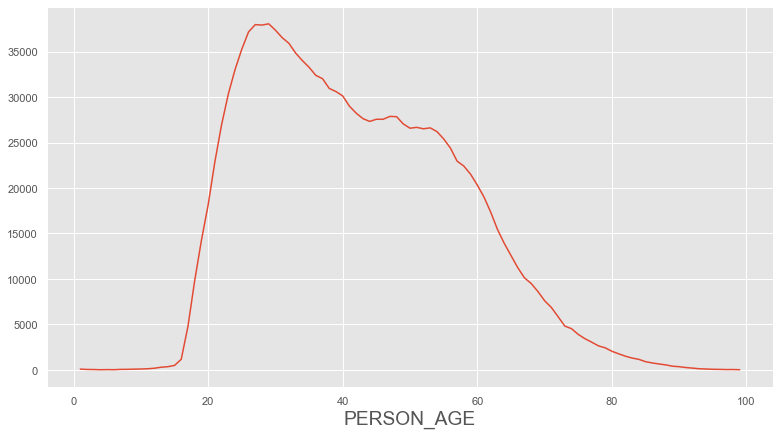

In [206]:
df_persons.groupby(df_persons['PERSON_AGE']).size().plot()

In [204]:
len(df_persons['COLLISION_ID'].unique())

806342

{'whiskers': [<matplotlib.lines.Line2D at 0x1f2323d7b88>,
 'caps': [<matplotlib.lines.Line2D at 0x1f292839c88>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f2323d7348>],
 'medians': [<matplotlib.lines.Line2D at 0x1f2a30581c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f2a3058c08>],
 'means': []}

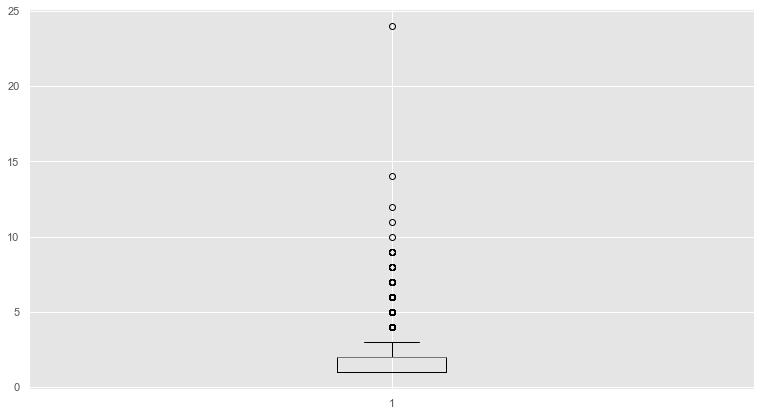

In [329]:
plt.boxplot(df_persons.groupby(df_persons['COLLISION_ID']).size().to_list())

In [330]:
df_persons.groupby(df_persons['COLLISION_ID']).size().describe()

count    806342.000000
mean          1.751752
std           0.537675
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max          24.000000
dtype: float64

In [205]:
len(df_persons['PERSON_ID'].unique())

1412505

In [207]:
len(df_persons['UNIQUE_ID'].unique())

1412511

In [199]:
df_persons.groupby(df_persons['PED_ROLE']).size()

PED_ROLE
Driver    1412511
dtype: int64

In [200]:
len(df_persons)

1412511

In [214]:
df_persons.head()

,Unnamed: 0,UNIQUE_ID,COLLISION_ID,CRASH_DATE,CRASH_TIME,PERSON_ID,PERSON_TYPE,PERSON_INJURY,VEHICLE_ID,PERSON_AGE,PED_ROLE,PERSON_SEX
6,6,10253976,4230620,10/16/2019,19:50,3983bcbc-dbd6-436f-a499-70189612dad7,Occupant,Unspecified,19143533.0,24.0,Driver,M
10,10,10251466,4230173,10/26/2019,10:09,1f8c9a16-c923-4aa3-9186-10f787da9607,Occupant,Unspecified,19142265.0,49.0,Driver,F
12,12,10253327,4230898,10/24/2019,8:30,1d8be50e-1022-4015-a414-51a2b1dfa3e9,Occupant,Injured,19143203.0,23.0,Driver,F
16,16,10254020,4230630,10/25/2019,9:16,4cb94df9-d924-4cd3-ab30-0242989d5c17,Occupant,Unspecified,19143554.0,34.0,Driver,F
17,17,10254288,4224023,10/16/2019,10:43,484cb52c-499c-47d7-9ac5-eabdffda3c09,Occupant,Unspecified,19143686.0,33.0,Driver,F


In [306]:
df_sort = df_persons.groupby(['COLLISION_ID','PERSON_TYPE'],as_index=False).agg({'PERSON_AGE': ['min', 'max'],'PERSON_SEX': ['first','last']})

In [307]:
df_sort

COLLISION_ID PERSON_TYPE PERSON_AGE       PERSON_SEX     
                                       min   max      first last
0           3405175    Occupant       29.0  32.0          M    F
1           3405176    Occupant       47.0  64.0          F    M
2           3405178    Occupant       30.0  30.0          M    M
3           3405179    Occupant       32.0  58.0          M    M
4           3405180    Occupant       52.0  59.0          M    M
...             ...         ...        ...   ...        ...  ...
823547      4308975    Occupant       67.0  67.0          M    M
823548      4308998    Occupant       73.0  73.0          M    M
823549      4309021    Occupant       49.0  61.0          M    F
823550      4309026    Occupant       47.0  53.0          F    M
823551      4309045    Occupant       33.0  62.0          M    M

[823552 rows x 6 columns]

In [308]:
df_sort = df_sort[df_sort['COLLISION_ID'].notnull() == True].set_index('COLLISION_ID')
df_crash2 = df_crash[df_crash['COLLISION_ID'].notnull() == True].set_index('COLLISION_ID')

In [309]:
df_merged = pd.merge(df_crash2,df_sort, how='inner', left_index=True, right_index=True)

In [310]:
df_merged.head()

,Unnamed: 0,CRASH DATE,CRASH TIME,BOROUGH,LATITUDE,LONGITUDE,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,...,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,"(PERSON_TYPE, )","(PERSON_AGE, min)","(PERSON_AGE, max)","(PERSON_SEX, first)","(PERSON_SEX, last)"
COLLISION_ID,,,,,,,,,,,,,,,,,,,,,
3405176,398612,03/13/2016,18:30,MANHATTAN,40.724300,-73.981800,WEST STREET,MURRAY STREET,0,0,...,0,Driver Inattention/Distraction,Driver Inattention/Distraction,PASSENGER VEHICLE,PASSENGER VEHICLE,Occupant,47.0,64.0,F,M
3405192,406777,03/15/2016,14:00,MANHATTAN,40.703953,-74.011600,BROAD STREET,BRIDGE STREET,0,0,...,0,Passing Too Closely,Passing Too Closely,PASSENGER VEHICLE,SMALL COM VEH(4 TIRES),Occupant,36.0,53.0,M,M
3405193,403643,03/15/2016,9:00,MANHATTAN,40.713240,-74.007090,BROADWAY,MURRAY STREET,0,0,...,0,Passing or Lane Usage Improper,Unspecified,PASSENGER VEHICLE,Unspecified,Occupant,29.0,35.0,M,M
3405200,392099,03/14/2016,21:15,MANHATTAN,40.727154,-74.005554,VARICK STREET,VANDAM STREET,0,0,...,0,Driver Inexperience,Unspecified,PASSENGER VEHICLE,PASSENGER VEHICLE,Occupant,25.0,43.0,M,M
3405218,199192,03/18/2016,4:45,MANHATTAN,40.725773,-74.000910,PRINCE STREET,WEST BROADWAY,0,0.0,...,0,Failure to Yield Right-of-Way,Unspecified,PASSENGER VEHICLE,Unspecified,Occupant,27.0,49.0,M,M


In [311]:
df_merged.columns

Index([                   'Unnamed: 0',                    'CRASH DATE',
                          'CRASH TIME',                       'BOROUGH',
                            'LATITUDE',                     'LONGITUDE',
                      'ON STREET NAME',             'CROSS STREET NAME',
           'NUMBER OF PERSONS INJURED',      'NUMBER OF PERSONS KILLED',
       'NUMBER OF PEDESTRIANS INJURED',  'NUMBER OF PEDESTRIANS KILLED',
           'NUMBER OF CYCLIST INJURED',      'NUMBER OF CYCLIST KILLED',
          'NUMBER OF MOTORIST INJURED',     'NUMBER OF MOTORIST KILLED',
       'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
                 'VEHICLE TYPE CODE 1',           'VEHICLE TYPE CODE 2',
                   ('PERSON_TYPE', ''),           ('PERSON_AGE', 'min'),
                 ('PERSON_AGE', 'max'),         ('PERSON_SEX', 'first'),
                ('PERSON_SEX', 'last')],
      dtype='object')

In [312]:
df_merged = df_merged.rename(columns = {df_merged.columns[-1] : 'PERSON_SEX2'})
df_merged = df_merged.rename(columns = {df_merged.columns[-2] : 'PERSON_SEX1'})
df_merged = df_merged.rename(columns = {df_merged.columns[-3] : 'PERSON_AGE2'})
df_merged = df_merged.rename(columns = {df_merged.columns[-4] : 'PERSON_AGE1'})
df_merged = df_merged.rename(columns = {df_merged.columns[-5] : 'PERSON_TYPE'})

In [313]:
df_merged.head()

,Unnamed: 0,CRASH DATE,CRASH TIME,BOROUGH,LATITUDE,LONGITUDE,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,...,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,PERSON_TYPE,PERSON_AGE1,PERSON_AGE2,PERSON_SEX1,PERSON_SEX2
COLLISION_ID,,,,,,,,,,,,,,,,,,,,,
3405176,398612,03/13/2016,18:30,MANHATTAN,40.724300,-73.981800,WEST STREET,MURRAY STREET,0,0,...,0,Driver Inattention/Distraction,Driver Inattention/Distraction,PASSENGER VEHICLE,PASSENGER VEHICLE,Occupant,47.0,64.0,F,M
3405192,406777,03/15/2016,14:00,MANHATTAN,40.703953,-74.011600,BROAD STREET,BRIDGE STREET,0,0,...,0,Passing Too Closely,Passing Too Closely,PASSENGER VEHICLE,SMALL COM VEH(4 TIRES),Occupant,36.0,53.0,M,M
3405193,403643,03/15/2016,9:00,MANHATTAN,40.713240,-74.007090,BROADWAY,MURRAY STREET,0,0,...,0,Passing or Lane Usage Improper,Unspecified,PASSENGER VEHICLE,Unspecified,Occupant,29.0,35.0,M,M
3405200,392099,03/14/2016,21:15,MANHATTAN,40.727154,-74.005554,VARICK STREET,VANDAM STREET,0,0,...,0,Driver Inexperience,Unspecified,PASSENGER VEHICLE,PASSENGER VEHICLE,Occupant,25.0,43.0,M,M
3405218,199192,03/18/2016,4:45,MANHATTAN,40.725773,-74.000910,PRINCE STREET,WEST BROADWAY,0,0.0,...,0,Failure to Yield Right-of-Way,Unspecified,PASSENGER VEHICLE,Unspecified,Occupant,27.0,49.0,M,M


In [314]:
df_pre = df_merged[['PERSON_AGE1','PERSON_SEX1','BOROUGH']]

In [315]:
df_pre = pd.pivot_table(df_pre, values='BOROUGH', index=['PERSON_AGE1'], columns=['PERSON_SEX1'], aggfunc='count').fillna(0)

In [316]:
df_pre = df_pre.iloc[:,[0,1]] # removing unspecified børger

In [317]:
df_pre

PERSON_SEX1,F,M
PERSON_AGE1,,
1.0,5.0,17.0
2.0,2.0,16.0
3.0,4.0,14.0
4.0,2.0,7.0
5.0,6.0,5.0
6.0,2.0,7.0
7.0,6.0,16.0
8.0,7.0,20.0
9.0,8.0,26.0


In [318]:
age = [str(elem+1) for elem in df_pre.index.to_list()]

In [319]:
source = ColumnDataSource(df_pre)
stacks = df_pre.columns.to_list()

In [322]:
TOOLTIPS = [("PERSON_SEX1","$name"), ("Fraction","@$name")]
p = figure(x_range = FactorRange(factors = age),width=850,plot_height=500, tooltips=TOOLTIPS)

In [327]:
p.vbar_stack(stackers=stacks,x = 'PERSON_AGE1', color=['red', 'green'],width = 0.9,source= source)
p.xaxis.major_label_orientation = np.pi/4
show(p) #displays your plot

## Stacked Bokeh plot
In the plots below, the crashes of each gender is plotted in a stacked bar plot

In [292]:
df_gender_sex = df_vehicle[['VEHICLE_YEAR','DRIVER_SEX','COLLISION_ID']]
df_gender_sex = df_gender_sex[df_gender_sex['COLLISION_ID'].notnull() == True].set_index('COLLISION_ID')
df_crash2 = df_crash[df_crash['COLLISION_ID'].notnull() == True].set_index('COLLISION_ID')

In [293]:
df_merged = pd.merge(df_crash2,df_gender_sex, how='inner', left_index=True, right_index=True)

In [294]:
df_sex = df_merged[df_merged['CONTRIBUTING FACTOR VEHICLE 1'].isin(focusviolations)]
df_sex1 = df_merged[df_merged['VEHICLE TYPE CODE 1'].isin(focusvehicles)]

In [295]:
df_pre = df_sex[['CONTRIBUTING FACTOR VEHICLE 1','DRIVER_SEX','BOROUGH']]
df_pre1 = df_sex1[['VEHICLE TYPE CODE 1','DRIVER_SEX','BOROUGH']]

In [296]:
df_pre = pd.pivot_table(df_pre, values='BOROUGH', index=['DRIVER_SEX'], columns=['CONTRIBUTING FACTOR VEHICLE 1'], aggfunc='count').fillna(0)
df_pre1 = pd.pivot_table(df_pre1, values='BOROUGH', index=['DRIVER_SEX'], columns=['VEHICLE TYPE CODE 1'], aggfunc='count').fillna(0)

In [297]:
total = df_sex.groupby('CONTRIBUTING FACTOR VEHICLE 1').size()
total_vehicles = df_sex1.groupby('VEHICLE TYPE CODE 1').size()

In [298]:
df_pre = df_pre.div(total,axis = 1)
df_pre.reset_index()

CONTRIBUTING FACTOR VEHICLE 1,DRIVER_SEX,Backing Unsafely,Driver Inattention/Distraction,Driver Inexperience,Failure to Yield Right-of-Way,Fatigued/Drowsy,Following Too Closely,Lost Consciousness,Other Vehicular,Passing Too Closely,Passing or Lane Usage Improper,Prescription Medication,Traffic Control Disregarded,Turning Improperly,Unsafe Lane Changing
0,F,0.089674,0.120125,0.096339,0.144659,0.002117,0.241791,0.003560,0.062727,0.161852,0.191699,0.000510,0.135772,0.100149,0.218376
1,M,0.241162,0.344634,0.253879,0.351828,0.007084,0.649752,0.011562,0.195781,0.526593,0.605653,0.001138,0.366965,0.295129,0.693417
2,U,0.669164,0.535242,0.649782,0.503514,0.990799,0.108457,0.984878,0.741492,0.311556,0.202648,0.998352,0.497263,0.604723,0.088207


In [299]:
df_pre1 = df_pre1.div(total_vehicles,axis = 1)
df_pre1.reset_index()

VEHICLE TYPE CODE 1,DRIVER_SEX,Ambulance,Box Truck,Bus,LARGE COM VEH(6 OR MORE TIRES),Motorcycle,OTHER,Pick-up Truck,SMALL COM VEH(4 TIRES),Sedan,Taxi,UNKNOWN,Van
0,F,0.183114,0.092489,0.188221,0.000203,0.114421,0.001259,0.125522,0.002769,0.227169,0.089214,0.000453,0.102648
1,M,0.589912,0.731007,0.668837,0.003807,0.638456,0.007667,0.699082,0.021274,0.568326,0.788603,0.002596,0.707128
2,U,0.226974,0.176504,0.142942,0.995990,0.247123,0.991074,0.175396,0.975958,0.204505,0.122183,0.996951,0.190224


In [300]:
gender = df_pre.index.to_list()

In [304]:
gender

['F', 'M', 'U']

In [301]:
source = ColumnDataSource(df_pre)
stacks = df_pre.columns.to_list()

source1 = ColumnDataSource(df_pre1)
stacks1 = df_pre1.columns.to_list()

In [302]:
TOOLTIPS = [("Contributing Factor","$name"), ("Fraction","@$name")]
p = figure(x_range = FactorRange(factors = gender),width=850,plot_height=500, tooltips=TOOLTIPS)

In [303]:
p.vbar_stack(stackers=stacks,x = 'DRIVER_SEX',width = 0.9,source= source,color=palette2)
show(p) #displays your plot

In [36]:
TOOLTIPS = [("Vehicly Type","$name"), ("Fraction","@$name")]
p = figure(x_range = FactorRange(factors = gender),width=850,plot_height=500, tooltips=TOOLTIPS)

In [37]:
stacks1

['Ambulance',
 'Bicycle',
 'Box Truck',
 'Bus',
 'LARGE COM VEH(6 OR MORE TIRES)',
 'Livery Vehicle',
 'Motorcycle',
 'OTHER',
 'Pick-up Truck',
 'SMALL COM VEH(4 TIRES) ',
 'Sedan',
 'Station Wagon',
 'Taxi',
 'UNKNOWN',
 'Van']

In [38]:
p.vbar_stack(stackers=stacks1,x = 'DRIVER_SEX',width = 0.9,source= source1,color=palette2)
show(p) #displays your plot

ValueError: Keyword argument sequences for broadcasting must be the same length as stackers

## Bokeh plot #2

In [ ]:
df_borough = df_crash[df_crash['CONTRIBUTING FACTOR VEHICLE 1'].isin(focusviolations)]

In [ ]:
df_pre = df_borough[['CONTRIBUTING FACTOR VEHICLE 1','BOROUGH','COLLISION_ID']]

In [ ]:
df_pre = pd.pivot_table(df_pre, values='COLLISION_ID', index=['BOROUGH'], columns=['CONTRIBUTING FACTOR VEHICLE 1'], aggfunc='count').fillna(0)

In [ ]:
total = df_borough.groupby('CONTRIBUTING FACTOR VEHICLE 1').size()

In [ ]:
df_pre = df_pre.div(total,axis = 1)
df_pre.reset_index()

In [ ]:
boroughs = df_pre.index.to_list()

In [ ]:
source = ColumnDataSource(df_pre)
stacks = df_pre.columns.to_list()

In [ ]:
TOOLTIPS = [("Contributing Factor","$name"), ("Fraction","@$name")]
p = figure(x_range = FactorRange(factors = boroughs),width=850,plot_height=500, tooltips=TOOLTIPS)

In [ ]:
p.vbar_stack(stackers=stacks,x = 'BOROUGH',width = 0.9,source= source,color=palette2)
show(p) #displays your plot

In [ ]:
from folium import plugins
from folium.plugins import HeatMap

map_NYC = folium.Map(location=[40.7128, -74.0060],zoom_start = 13) 

# Filter the DF for rows, then columns, then remove NaNs
mask = (df_crash['NUMBER OF PERSONS KILLED'] == np.float64(1.0)) 
df_killcrash = df_crash.loc[mask]
df_map_NYC_kill = df_killcrash[['LATITUDE', 'LONGITUDE']]
df_map_NYC_kill = df_map_NYC_kill.dropna(axis=0, subset=['LATITUDE', 'LONGITUDE'])

# List comprehension to make out list of lists
heat_data = [[row['LATITUDE'],row['LONGITUDE']] for index, row in df_map_NYC_kill.iterrows()]

# Plot it on the map
HeatMap(heat_data,radius=9,blur = 10).add_to(map_NYC)

#HeatMap(heat_dataC,radius=5).add_to(map_NYC)

# Display the map
map_NYC

In [ ]:
plt.figure(figsize=(15,10))
violations = []
idx = 1
for elem1 in focusviolations:
    for elem2 in focusviolations:
        if elem1 != elem2 and elem2 not in violations:  # 
            plt.subplot(13,7,idx)
            Main = df_crash[df_crash['CONTRIBUTING FACTOR VEHICLE 1'] == elem1]
            Comp = df_crash[df_crash['CONTRIBUTING FACTOR VEHICLE 1'] == elem2]
            x = Main.groupby(Main['CRASH TIME'].dt.hour).size().to_list()
            y = Comp.groupby(Comp['CRASH TIME'].dt.hour).size().to_list()
            plt.scatter(x,y)
            plt.xlabel(elem1)
            plt.ylabel(elem2)
            idx+=1
    violations.append(elem1)
plt.tight_layout()    
plt.show()